In [22]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from glob import glob
import os
import yaml
from skimage.io import imread
import stretchablecorr as sc

# Stretchable Corr - Post-process

## Search and select images

In [23]:
def get_stretch(image_name, sample_name):
    """extract stretch value from filename

    ex: hpr10p100031.TIF --> 0.1%
    """
    image_name = image_name.replace(sample_name, '')
    image_name = image_name.split('.')[0]
    u, d = image_name.split('p')
    d = d[:2]
    s = float(u) + float(d)/100
    return s

Available samples
0 - example_PDMS_18j
1 - .ipynb_checkpoints
2 - HS2_0p0
3 - gris_e_zoom8
4 - calibration
5 - calib_bruit_camera_x2
6 - calib_bruit_camera_x11.5
7 - HS2
8 - calib_distortion_gris_x2


> Select an image directory: 0


example_PDMS_18j selected
Load images from ./images/example_PDMS_18j...
Image sequence:
 28 frames , 1360*1024 pixels , memory size: 297 Mo
 images: output_0001.tiff, output_0002.tiff, output_0003.tiff , ... ,  output_0028.tiff


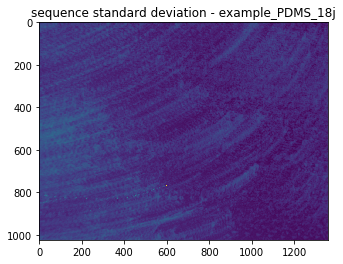

In [25]:
# ==================
#  Load image cube
# ==================
sample_name, sample_input_dir = sc.select_sample_dir('./images')
cube, image_names = sc.load_image_sequence(sample_input_dir)

output_dir = 'output'
resultdir = os.path.join(output_dir, sample_name)

# Graph std
plt.figure(); plt.title(f'sequence standard deviation - {sample_name}');
plt.imshow(np.std(cube, axis=0), cmap='viridis');
sc.save_fig('01_cube_std', sample_name, output_dir=output_dir)

# Extract stretch value from filenames
#stretch_values = [get_stretch(n, 'hpr1') for n in image_names]
#print('\n', f'{len(stretch_values)} stretch values extracted')

## Lagrangian displacement

In [27]:
# ========================
#  List available dataset
# ========================
datasets = glob(os.path.join(resultdir, '*.pck'))

print(f'Available dataset for {sample_name}')
print( '======================' + '='*len(sample_name) )
sc.print_numbered_list([os.path.basename(d) for d in datasets])

# Select a sample:
dataset_id = input('> Select a file:')
data_file = datasets[int(dataset_id)]
print(data_file)

# Load dataset
with open(data_file, 'rb') as f:
    grid, displ, err, meta = pickle.load(f)

window_half_size = meta['window_half_size']
points = np.stack( (grid[0].flatten(), grid[1].flatten()), axis=-1 )

print('')
print('Parameters:')
print('===========')
print( yaml.dump(meta, default_flow_style=False))

Available dataset for example_PDMS_18j
0 - displ_Lagrangian_150pts_175347.pck


> Select a file: 0


output/example_PDMS_18j/displ_Lagrangian_150pts_175347.pck

Parameters:
coarse_downscale: 3
coarse_param:
  method: opti
  phase: true
  window_half_size: 35
grid_margin: 150
grid_spacing: 75
method: opti
phase: false
sample_name: example_PDMS_18j
window_half_size: 20



In [31]:
# =========================
#  Load an image as a mask
# =========================
try:
    image_mask = imread(f'images/{sample_name}_mask.png')
    image_mask = ~(image_mask[:, :, -1] < 150)

    points_mask = image_mask[points[:, 1], points[:, 0]]
    points_mask = points_mask.reshape(grid[0].shape).astype(np.int)

    plt.title('image mask')
    plt.imshow(image_mask)

    #points_mask = np.logical_not( points_mask )
    #print(points_mask[0, 0])
except:
    print('no image mask')
    points_mask = None

no image mask


In [32]:
displ_to_ref = sc.integrate_displacement(displ)

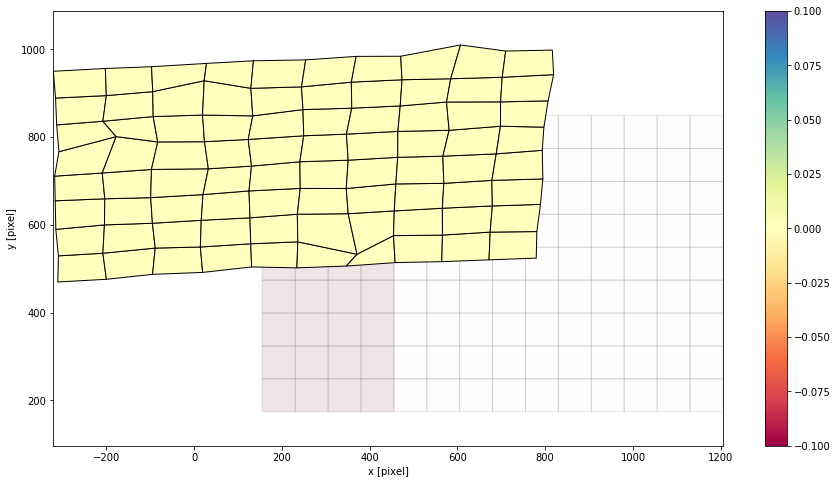

In [33]:
plt.figure(figsize=(15, 8));
sc.plot_deformed_mesh(grid, displ_to_ref[19],
                      color_values=points_mask,
                      view_factor=2)

### Deformed mesh for all steps

In [34]:
def finite_diff_strain(grid, displ_field, nu=0.33):
    # not exactly...
    # instantaneous or absolute ? grid(t)...
    # see Bower page 72
    x, y = grid

    dx = np.diff(x, axis=1, append=np.NaN)
    dy = np.diff(y, axis=0, append=np.NaN)

    u = displ_field[:, 0].reshape(grid[0].shape)
    v = displ_field[:, 1].reshape(grid[0].shape)
    
    dudx = np.diff(u, axis=0, append=np.NaN) / dx
    dvdy = np.diff(v, axis=0, append=np.NaN) / dy 

    # Poisson coeff
    eps_33 = (dudx + dvdy)*nu/(1-2*nu)/(1+nu)
    
    return dudx*100, dvdy*100, eps_33*100


 done


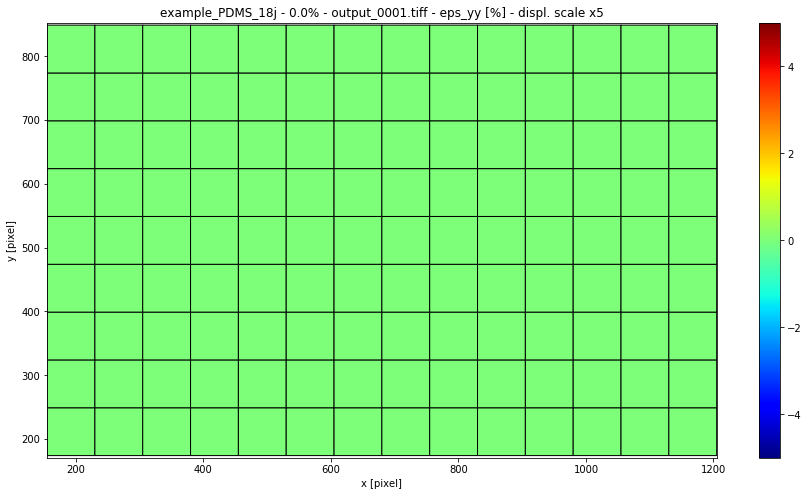

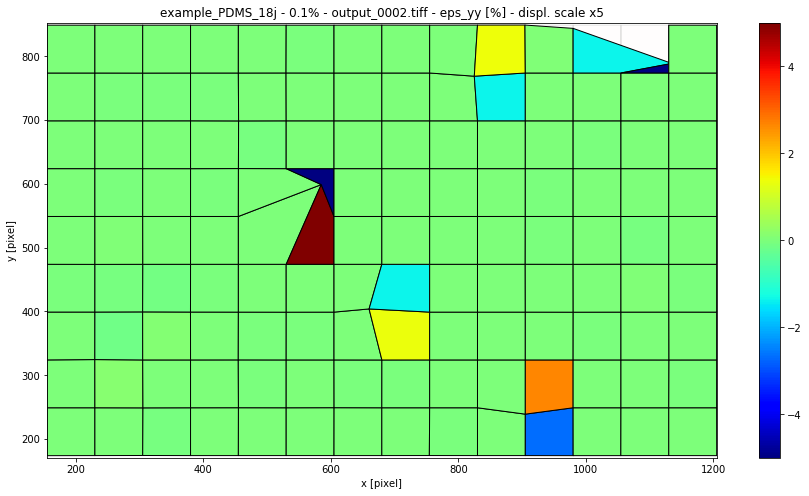

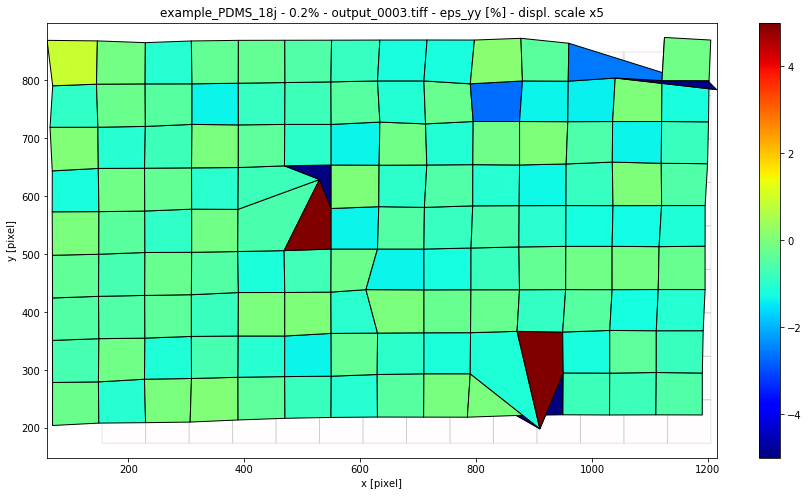

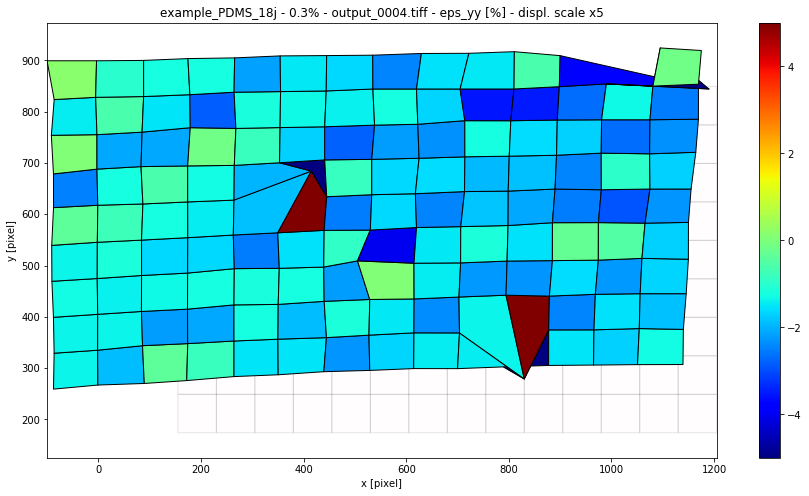

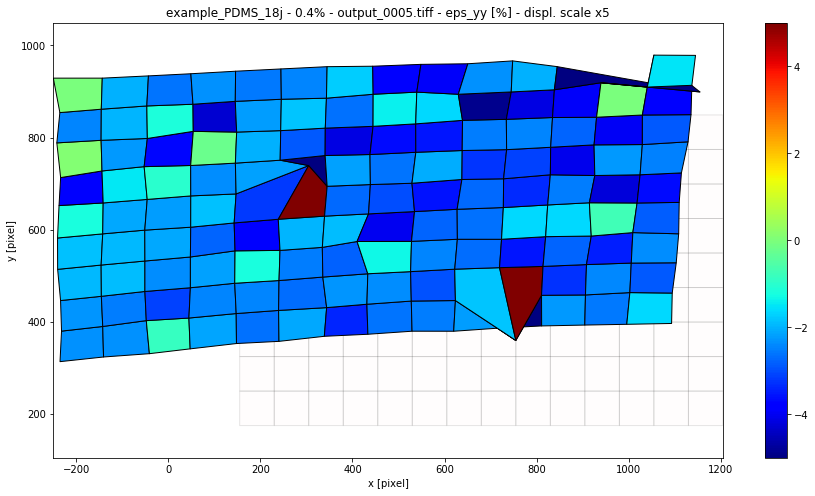

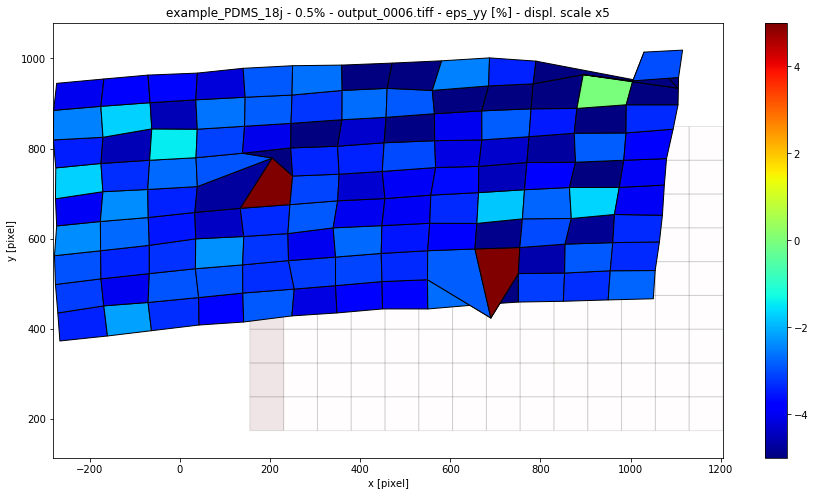

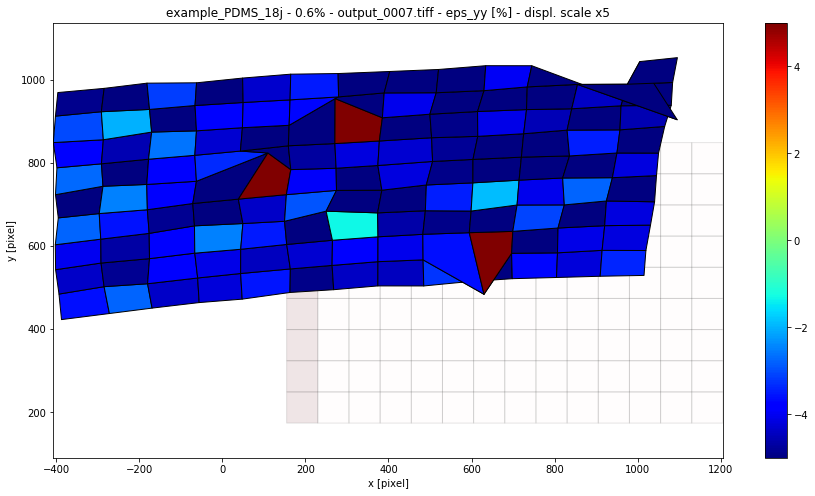

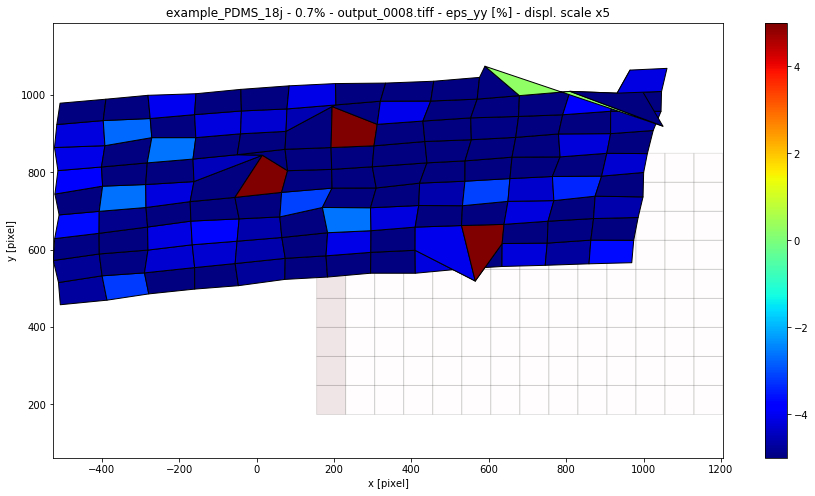

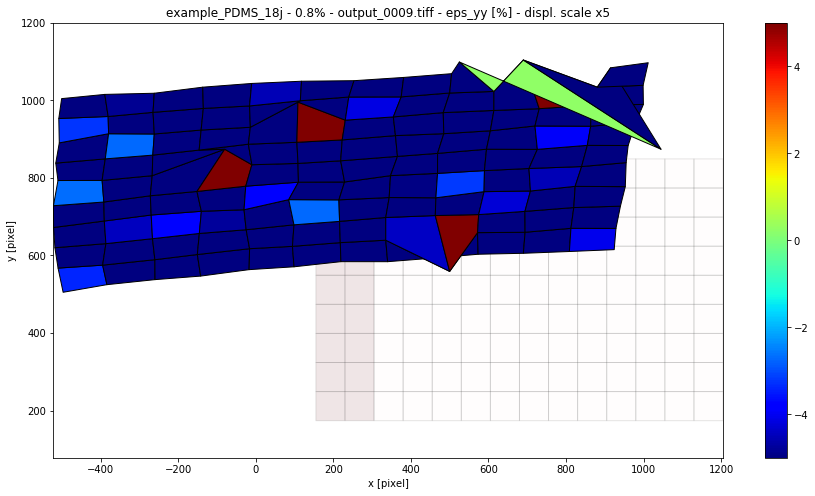

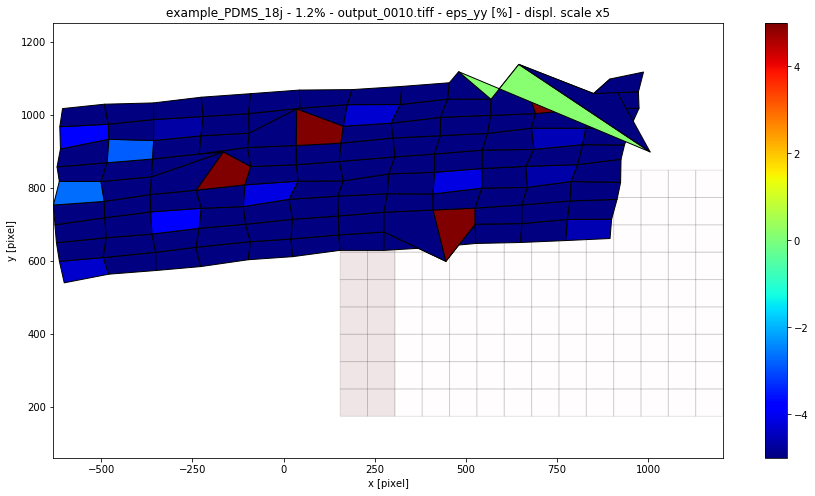

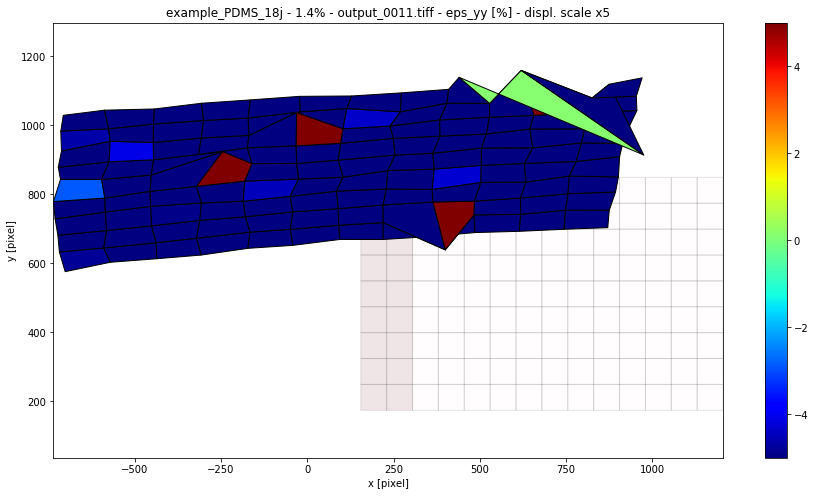

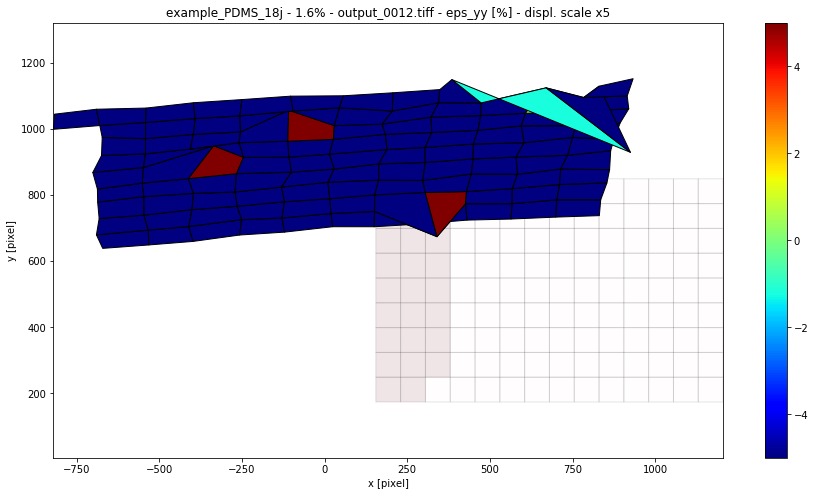

In [36]:
view_factor = 5
Poisson_coeff = 0.3
eps_zz_limits = -5, 5 # None  #
save = False

for image_id, displ_field in enumerate(displ_to_ref[:12]):

    eps_xx, eps_yy, eps_zz = finite_diff_strain(grid, displ_field, nu=Poisson_coeff)
    field_value = eps_yy
    field_value_name = 'eps_yy'
    
    if points_mask is not None:
        field_value[points_mask] = np.NaN
    
    plt.figure(figsize=(15, 8));
    sc.plot_deformed_mesh(grid, displ_field,
                          color_values=field_value,
                          view_factor=view_factor,
                          cmap='jet') #Spectral

    if eps_zz_limits:
        plt.clim(*eps_zz_limits)
    else:
        clim = np.nanmax(np.abs(field_value))
        plt.clim([-clim, +clim])
        
    title =  f'{sample_name} - {stretch_values[image_id]}% - '
    title += f'{image_names[image_id]} - '
    #title += f'eps_zz [%] (nu={Poisson_coeff}) - '
    title += f'{field_value_name} [%] - '
    title += f'displ. scale x{view_factor}'
    plt.title(title);
    
    if save:
        output_dir = f'{field_value_name}_maps' if points_mask is None else f'{field_value_name}_maps_mask'
        sc.save_fig(f'{field_value_name}_{image_id:03d}',
                    sample_name,
                    output_dir, close=True)
    
print('\n done')